# Line Tracing #

## Idea ##

Function: Main
1) Load 1 pixel Image
2) Give every pixel a id
3) Select a Starting Point
Function: Trace Line
1) Check all Pixels surrounding the Starting Point

In [1]:
import utils
import classes
import matplotlib.pyplot as plt
import networkx as nx
import igraph as g
import json
import math as m
import cv2

In [2]:
imageArray = utils.loadImage("./../src/testImages","4.jpg",transpose=False,binary=True)
colorImage = utils.loadImage("./../src/testImages","4.jpg",transpose=False,color=True)
print(colorImage)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


[325, 45]
[549, 208]
[419, 343]
end reached


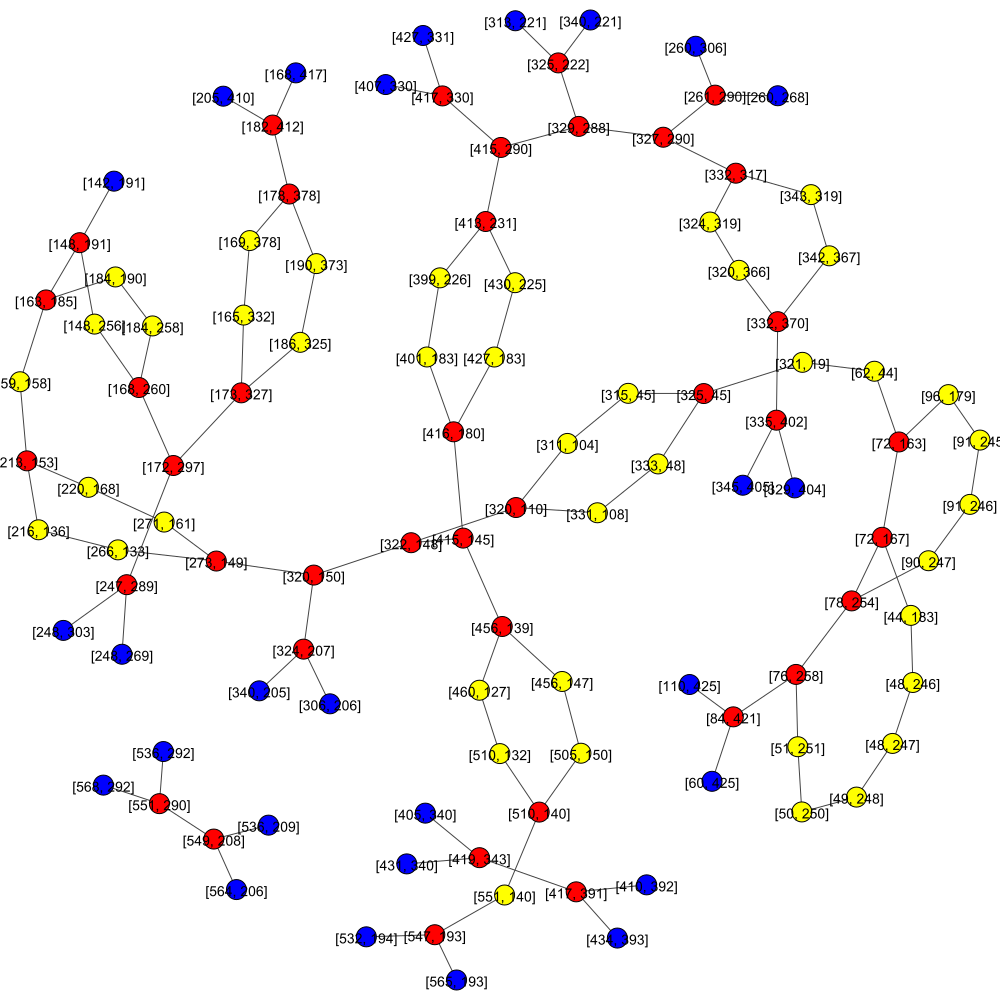

In [3]:
class NodeType():
    pass
class EndNode(NodeType):
    pass
class IntersectionNode(NodeType):
    pass 
class CornerNode(NodeType):
    pass
        

def getAdjacentPixel(image,currentPixel,blackList):
    #AdjacentPixel Array       
    adjacentPixels = [[-1,-1],[0,-1],[1,-1], \
                        [-1,0],        [1,0], \
                        [-1,1], [0,1], [1,1]]
    validPixels = []
    for adj in adjacentPixels:
        adjacentPixel = [currentPixel[0]+adj[0],currentPixel[1]+adj[1]]
        if image[adjacentPixel[1]][adjacentPixel[0]] == 255:
            if not adjacentPixel in blackList:
                validPixels.append(adjacentPixel)
    return validPixels

# gets first black pixel in image
def findStaringPoint(image):
    for y in range(0,len(image)):
        for x in range(0,len(image[y])):
            if image[y][x] == 255:
                return [x,y]

## Runs along line until it finds the first Intersection or the first Endpoint
def findValidPoint(image,startPoint):
    def recursiveFindValidPoint(currentPixel,lastPixel,dir):
        
        adjacentPixels = getAdjacentPixel(image,currentPixel,[])
        if len(adjacentPixels) > 2:
            return currentPixel
        elif len(adjacentPixels) == 1:
            return recursiveFindValidPoint(adjacentPixels[dir],currentPixel,-1)
        else:
            adjacentPixels = getAdjacentPixel(image,currentPixel,[lastPixel]) 
            return recursiveFindValidPoint(adjacentPixels[dir],currentPixel,dir)
    return recursiveFindValidPoint(startPoint,None,0)



def generateGraph(image,startPoint):
    visitedPixels = []
    graph = g.Graph(directed=False)
    graph.add_vertex(str(startPoint), label=str(startPoint) ,color="red")
    
    def recursiveGenerateGraph(currentPixel,lastPixel,lastGraphNode,dirGradientOld):
        dirGradient = list(dirGradientOld)

        #get Direction
        if(abs(currentPixel[0] - lastPixel[0]) < abs(currentPixel[1] - lastPixel[1])):
            dirGradient.append(1)
        else:
            dirGradient.append(0)

        #End Recursion if loop ends
        if currentPixel in visitedPixels:
            if len(graph.vs.select(name=str(currentPixel))):
                graph.add_edge(str(lastGraphNode),str(currentPixel))
            return

        visitedPixels.append(currentPixel)
        adjacentPixels = getAdjacentPixel(image,currentPixel,[lastPixel])
        if len(adjacentPixels) == 0:
            #ENDPOINT
            if(str(currentPixel) != lastGraphNode):
                graph.add_vertex(str(currentPixel),label=str(currentPixel),color="blue", nodeType=EndNode())
                graph.add_edge(str(lastGraphNode),str(currentPixel))
        elif len(adjacentPixels) == 1:
            #LINE
            if len(dirGradient) > 6:
                currDire = sum(dirGradient[-4:])/4 < 0.5
                lastDire = sum(dirGradient[-5:-1])/4 < 0.5
                if not  currDire == lastDire:
                    graph.add_vertex(str(currentPixel),label=str(currentPixel),color="yellow")
                    graph.add_edge(str(lastGraphNode),str(currentPixel))
                    #colorImage[currentPixel[1],currentPixel[0]] = (0,255,255,255)
                    recursiveGenerateGraph(adjacentPixels[0],currentPixel,str(currentPixel),dirGradient)
                else:
                    recursiveGenerateGraph(adjacentPixels[0],currentPixel,lastGraphNode,dirGradient)
            else:
                recursiveGenerateGraph(adjacentPixels[0],currentPixel,lastGraphNode,dirGradient)
        else:
            #INTERSECTION
            if(str(currentPixel) != lastGraphNode):
                graph.add_vertex(str(currentPixel),label=str(currentPixel),color="red",nodeType=IntersectionNode())
                graph.add_edge(str(lastGraphNode),str(currentPixel))
            for adjacentPixel in adjacentPixels:
                recursiveGenerateGraph(adjacentPixel,currentPixel,str(currentPixel),[])

    recursiveGenerateGraph(startPoint,[0,0],str(startPoint),[])
    return graph,visitedPixels

graphCollection = []
while True:
    startingPoint = findStaringPoint(imageArray)
    if(startingPoint):
        startingPoint = findValidPoint(imageArray,startingPoint)
        print(startingPoint)
        G,visitedPixels = generateGraph(imageArray,startingPoint)
        graphCollection.append(G)
        #Remove all visited Pixels
        for visitedPixel in visitedPixels:
            imageArray[visitedPixel[1]][visitedPixel[0]] = 0
        #Check if image is only white
        summe = 0
        def addSum(pixel):global summe; summe += pixel
        utils.foreachPixel(imageArray,addSum)
        if summe == 0:
            print("end reached")
            break
    else:
        print("stoped before end")
        break

union = g.union(graphCollection)

layout = union.layout("fr")
g.plot(union, layout=layout,bbox = (1000,1000))

#### Pattern detection

In [4]:
def getColorList(graph):
    colorList = []
    for vert in graph.vs:
        if vert["color"] == "red":
            colorList.append(0)
        elif vert["color"] == "blue":
            colorList.append(1)
        elif vert["color"] == "yellow":
            colorList.append(2)
        elif vert["color"] == "white":
            colorList.append(3)
    return colorList

def getPatternMatches(graph,pattern,sort=False):
    mapings = graph.get_subisomorphisms_vf2(pattern,color1=getColorList(graph),color2=getColorList(pattern))
    result = []
    for i in range(0,len(mapings),1):
        if(sort):
            result.append(sorted(list( map(lambda node:json.loads(union.vs.find(node)["label"]) ,mapings[i]) )))
        else:
            result.append(list( map(lambda node:json.loads(union.vs.find(node)["label"]) ,mapings[i]) ))

    #remove duplicated
    final = []
    for i in result:
        if i not in final:
            final.append(i)
    return final

def connectCapsTougehter(graph):
    ground = g.Graph(directed=False)
    ground.add_vertex(0,color="blue")
    ground.add_vertex(1,color="red")
    ground.add_vertex(2,color="blue")
    ground.add_edge(1,0)
    ground.add_edge(1,2)

    capMatches = getPatternMatches(graph,ground)
    for cap1Match in capMatches:
        cap1Coord = cap1Match[1]
        for cap2Match in capMatches:
            cap2Coord = cap2Match[1]
            if not cap2Coord == cap1Coord:
                if m.sqrt((cap2Coord[0] - cap1Coord[0])**2 + (cap2Coord[1] - cap1Coord[1])**2)  < 20:
                    #only if the two are not directly connected
                    numberOfNodesBetween = graph.shortest_paths_dijkstra(source=str(cap1Coord), target = str(cap2Coord), mode="all")[0][0]
                    if not numberOfNodesBetween == 1:
                        graph.vs.select(name=str(cap1Coord))['color'] = "white"
                        graph.vs.select(name=str(cap2Coord))['color'] = "white"
                        graph.add_edge(str(cap1Coord),str(cap2Coord))
                        graph.add_edge(str(cap2Coord),str(cap1Coord))
                        break
    return graph

def groundPattern():
    ground = g.Graph(directed=False)
    ground.add_vertex(0,color="blue")
    ground.add_vertex(1,color="red")
    ground.add_vertex(2,color="blue")
    ground.add_edge(1,0)
    ground.add_edge(1,2)
    return ground

def capPattern():
    cap = g.Graph(directed=False)
    cap.add_vertex(0,color="blue")
    cap.add_vertex(1,color="white")
    cap.add_vertex(2,color="blue")
    cap.add_edge(1,0)
    cap.add_edge(1,2)

    cap.add_vertex(3,color="blue")
    cap.add_vertex(4,color="white")
    cap.add_vertex(5,color="blue")
    cap.add_edge(4,3)
    cap.add_edge(4,5)

    cap.add_edge(4,1)
    cap.add_edge(1,4)
    return cap

def resistorPattern():
    res = g.Graph(directed=False)
    res.add_vertex(0,color="red")
    res.add_vertex(1,color="yellow")
    res.add_vertex(2,color="yellow")
    res.add_vertex(3,color="red")
    res.add_vertex(4,color="yellow")
    res.add_vertex(5,color="yellow")
    res.add_edge(0,1)
    res.add_edge(1,2)
    res.add_edge(2,3)
    res.add_edge(3,4)
    res.add_edge(4,5)
    res.add_edge(5,0)
    return res

def generateBoundingBox(listOfCoords,offset):
    xCoords = list(map(lambda x: x[0],listOfCoords))
    yCoords = list(map(lambda y: y[1],listOfCoords))

    #get smalles and biggest of each and create Box
    from_ = [min(xCoords)-offset,min(yCoords)-offset]
    to_ = [max(xCoords)+offset,max(yCoords)+offset]
    return [from_,to_]


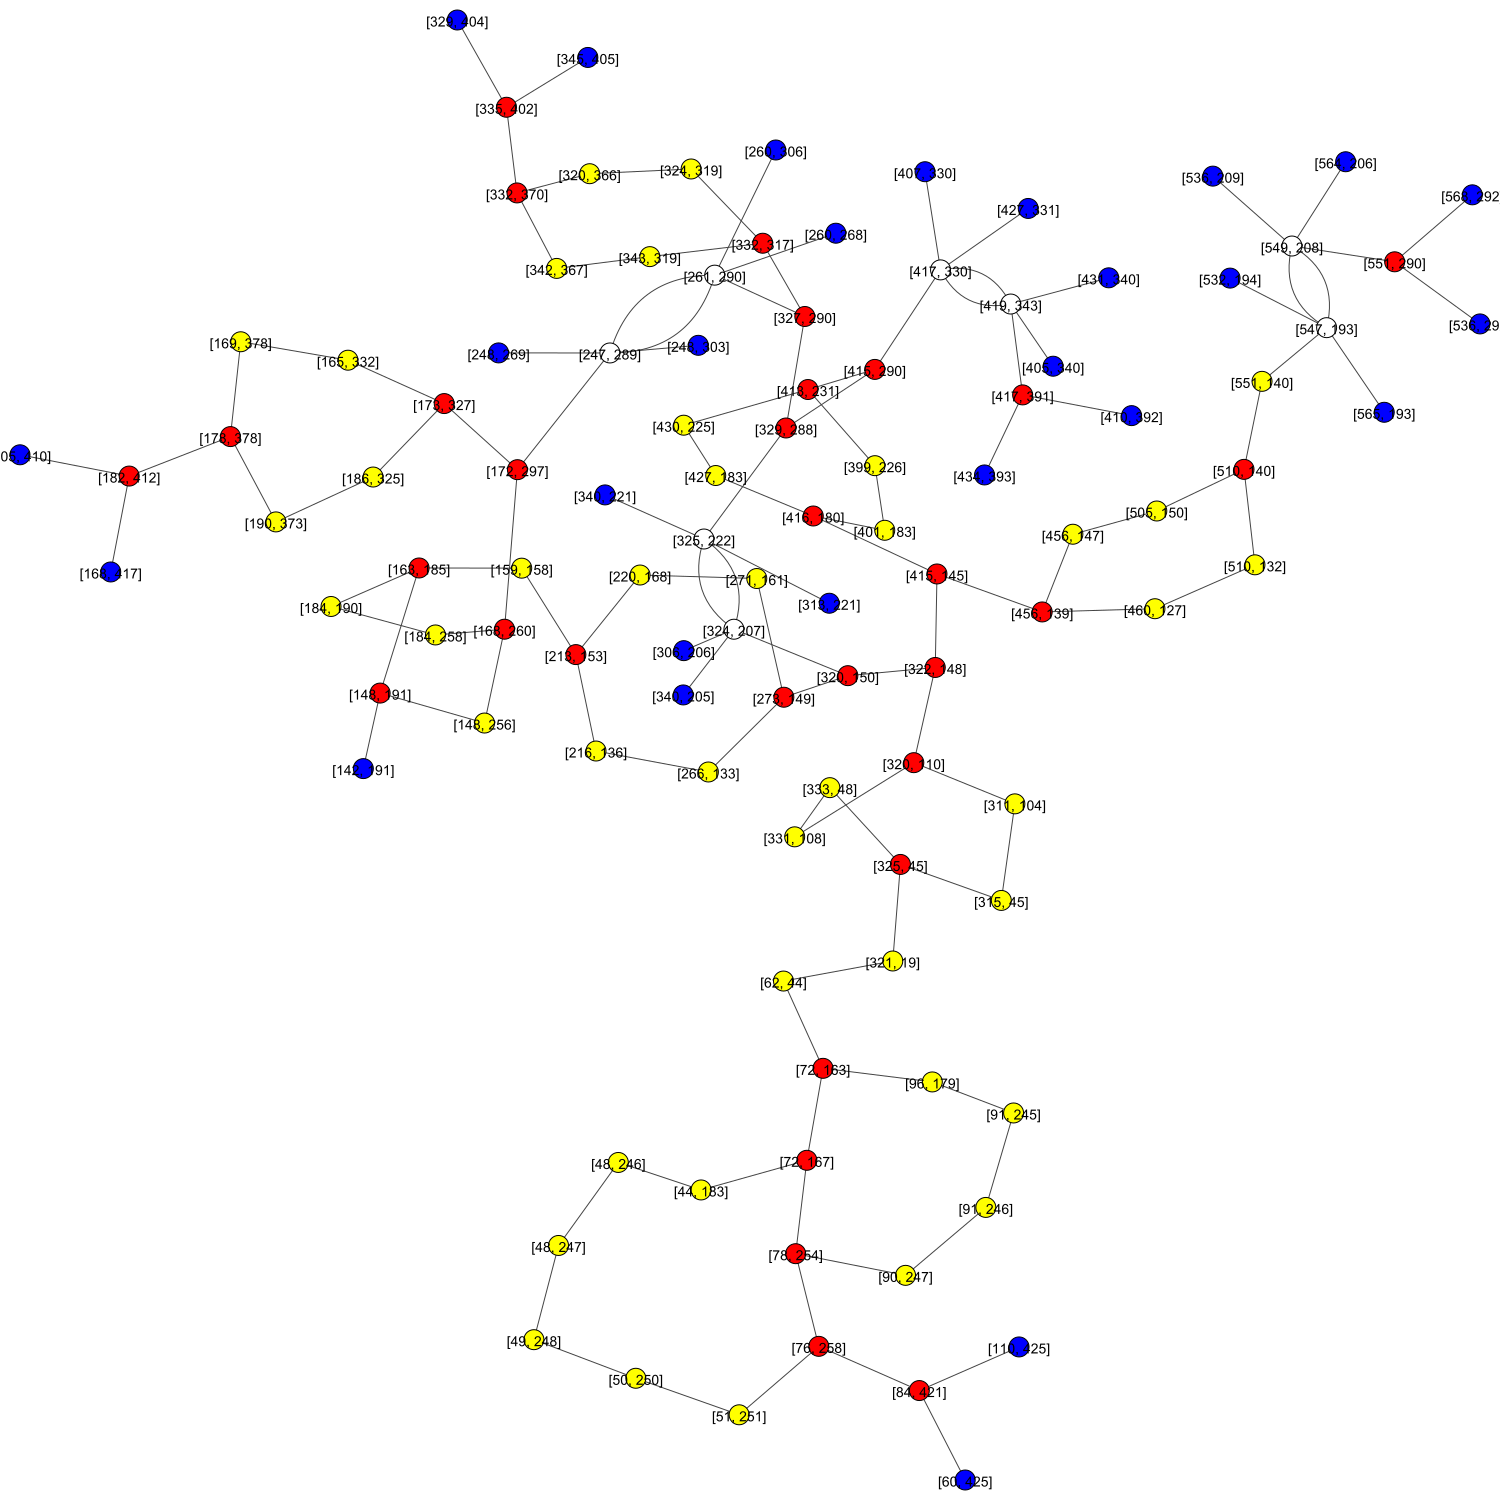

In [5]:
union = connectCapsTougehter(union)
layout = union.layout("large_graph")
g.plot(union, layout=layout,bbox=(1500, 1500))

[[[242, 263], [266, 311]], [[527, 188], [570, 214]], [[301, 200], [345, 227]], [[400, 325], [436, 348]], [[451, 122], [515, 155]], [[394, 175], [435, 236]], [[306, 40], [338, 115]], [[208, 128], [278, 173]], [[315, 312], [348, 375]], [[160, 320], [195, 383]], [[163, 405], [210, 422]], [[55, 416], [115, 430]], [[405, 386], [439, 398]], [[324, 397], [350, 410]], [[531, 285], [573, 297]]]


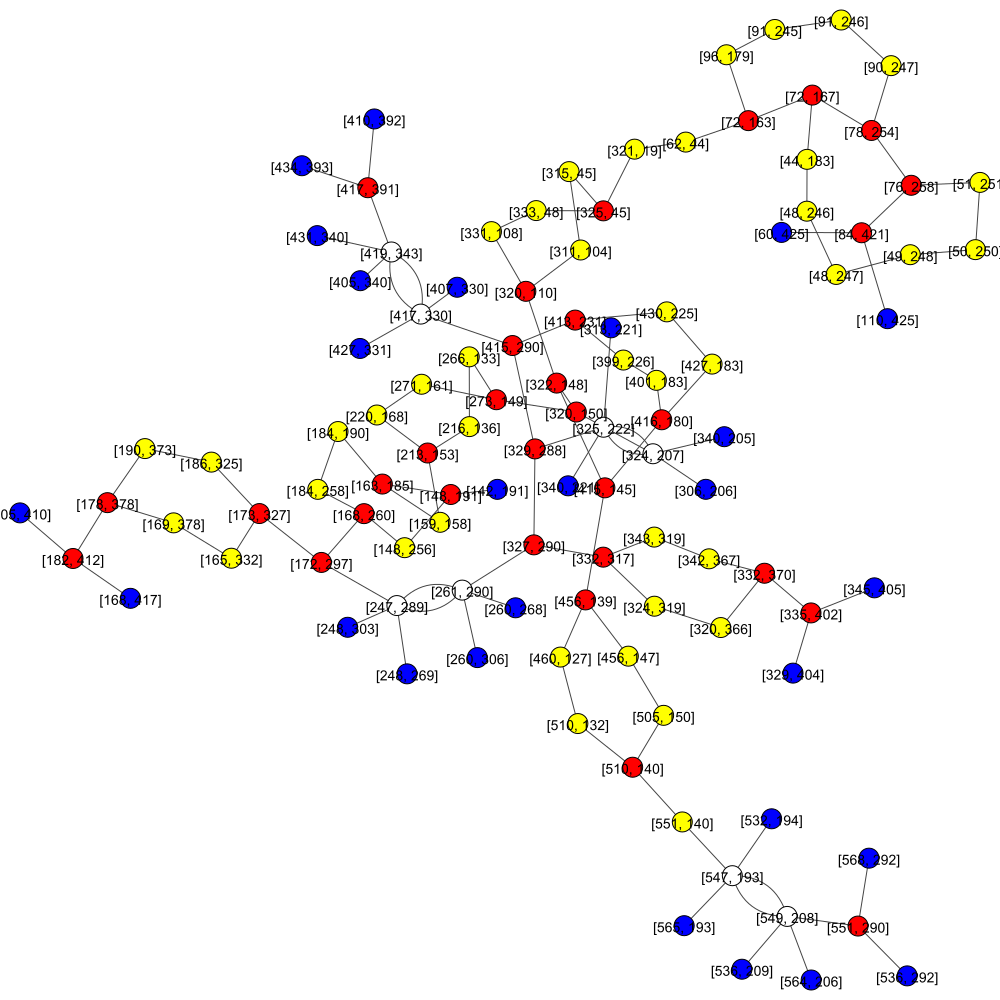

In [6]:
matches = getPatternMatches(union,capPattern(),True) + getPatternMatches(union,resistorPattern(),True) + getPatternMatches(union,groundPattern(),True)
boundingBoxes = list(map(lambda x: generateBoundingBox(x,5),matches))
print(boundingBoxes)


layout = union.layout("large_graph")
g.plot(union, layout=layout,bbox=(1000, 1000))

#fig, ax = plt.subplots()
#g.plot(union, layout=layout, target=ax,bbox=(300, 300))

In [8]:
def drawRect(image,boundingBoxes,color):
    corner1 = boundingBoxes[0]
    corner2 = boundingBoxes[1]
    startX = corner1[0]
    startY = corner1[1]

    endX = corner2[0]
    endY = corner2[1]

    for x in range(startX,endX):
        image[startY][x] = color
        image[endY][x] = color

    for y in range(startY,endY):
        image[y][startX] = color
        image[y][endX] = color

    return image

for boundingBox in boundingBoxes:
    drawRect(colorImage,boundingBox,(255,0,0))
colorImage = cv2.cvtColor(colorImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorImage,interpolation="bilinear")

NameError: name 'imcolorImageg' is not defined